In [ ]:
%matplotlib inline

# Welcome to the Dynamic Step Size Notebook

In the context of prognostics, `dt` or the step size in a integration method refers to the increment in time over which the system's behavior is approximated.

When you're numerically integrating a differential equation to predict a system's future state, you generally can't do it in a single step from the present to the future. Instead, you break up the future time span into smaller intervals or steps, each of size `dt`, and incrementally update the system's state at each step.

The choice of `dt` can have significant implications:

- __Accuracy__: If `dt` is too large, the approximation of the system's behavior might not be accurate, especially if the system's state changes rapidly with time. Smaller values of `dt` generally lead to more accurate approximations.

- __Computational Resources__: However, smaller values of `dt` also mean more computational steps, which can increase the computational resources required (both time and memory).

- __Stability__: In some cases, the choice of `dt` can also affect the numerical stability of the integration. If `dt` is too large, the integration might not converge to the correct solution.

In practice, the choice of `dt` is often a compromise between accuracy, computational efficiency, and stability. In some advanced methods, `dt` can be adaptively changed based on the specific characteristics of the problem to optimize these trade-offs.

In this notebook we will showcase an example demonstrating ways to use the dynamic step size feature, which is a myriad of ways to change the step size of the integration method!

### Importing Modules

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import prog_models
from prog_models.models.thrown_object import ThrownObject

### Example 1) Static Step Size

Before we demonstrate how to use the dynamic step size feature, let's first demonstrate how to use a static step size.

First, we'll need to define an instance of a model. For this example, we will use the ThrownObject model.

In [4]:
m = ThrownObject()

Next, we'll need to setup for the simulation, which is done by defining the `future_load()` function.

For this example, our future loading function will return an empty list, which is synonymous to no future loading at all.

In [6]:
def future_load(t, x=None):
    return {}

To call the function, we simply need to define the `dt` argument, and pass a number.

Furthermore, we will set our threshold_keys argument to 'impact', which will trigger the end of simulation when the object impacts the ground.

Finally, we will set our save_freq to a very small number, 1e-99, so we will track the motion of the object throughout the entire simulation.

In [88]:
simulated_results = m.simulate_to_threshold(future_load, save_freq=1e-99, dt = 1, threshold_keys=['impact'])

Let's plot the `simulated_results` and see what output of the ThrownObject model looks like with a `dt` value of 1.

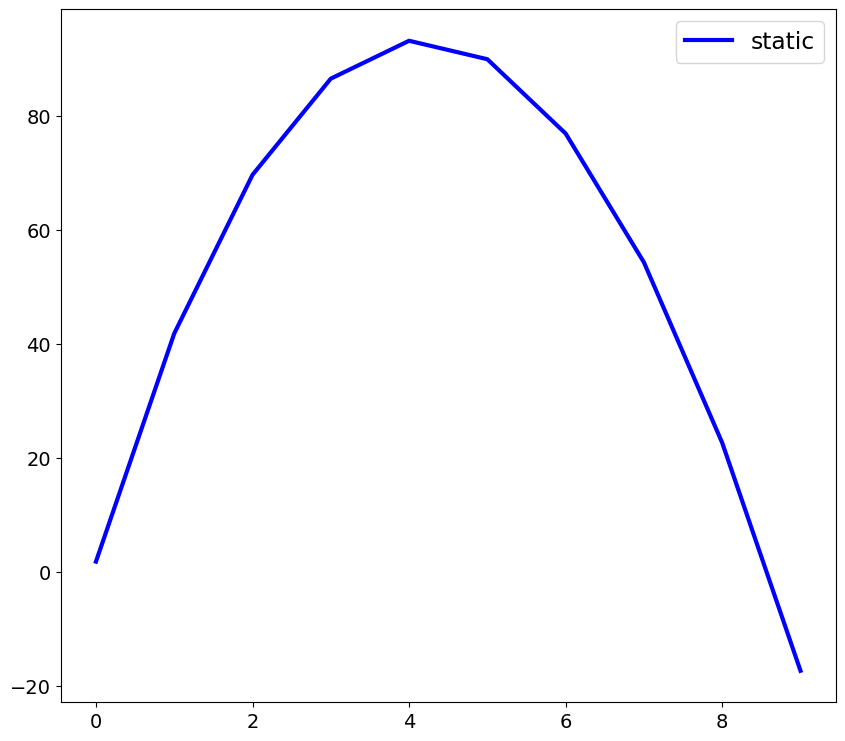

In [89]:
plt.plot(simulated_results.outputs, color='blue', label='static')

plt.legend()
plt.show()

### Example 2) Functional Dynamic Step Size: Changing `dt` after a certain time

In this example, we'll demonstrate a use case of the functional dynamic step size feature. This feature allows users to pass in functions to the `dt` argument!

First, we'll need to define an instance of a model. For this example, we will use the simple ThrownObject model.

In [9]:
m = ThrownObject()

Now, we'll need to create a setup for simulation, which is done by creating the future_load function!

In [27]:
def future_load(t, x=None):
    return {}

For our next step, let's define the dynamic step size function. This function will take in the current time and state, and return the desired `dt`.

The function we'll create will change depending on the time. If the time is less than 6, we'll return 1, otherwise we'll return 0.5! We'll dub the function the `next_time` function.

In [28]:
# f(x, t) -> (t, dt)
def next_time(t, x):
    if t < 6:
        return 1
    return 0.5

After creating the dynamic step size function, we can now create the simulated results! Here, we'll print every time step so we can see the step size change.

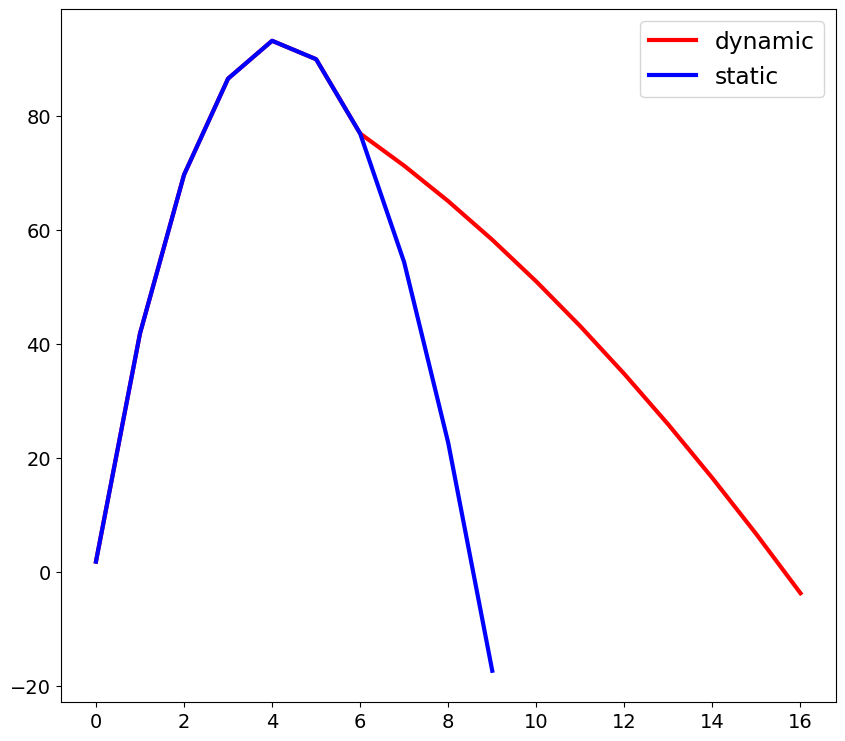

In [44]:
# New Results
simulated_results_dynamic = m.simulate_to_threshold(future_load, save_freq=1e-99, dt=next_time, threshold_keys=['impact'])
plt.plot(simulated_results_dynamic.outputs, color='red', label='dynamic')
# Previous Example
simulated_results = m.simulate_to_threshold(future_load, save_freq=1e-99, dt = 1, threshold_keys=['impact'])
plt.plot(simulated_results.outputs, color='blue', label='static')

plt.legend()
plt.show()

__NOTE__: Notice how the step size changes after 6 seconds, which in turn creates a different result for the output values of the ThrownObject Simulation!

### Example 3) Functional Dynamic Step Size: `dt` Changes due to State Change

In this example, we will have a `dt` of 1 until impact state event of impact is less than 0.75, then we'll change our `dt` value to 0.25!

We'll us the same ThrownObject from the first example, so we can skip the first couple steps and simply create the Dynamic Step Size function.

In [40]:
# f(x, t) -> (t, dt)
def next_time(t, x):
    # In this example dt is a function of state. Uses a dt of 1 until impact event state 0.5, then 0.25
    event_state = m.event_state(x)
    if event_state['impact'] < 0.75:
        return 0.25
    return 1

Now, let's simulate the results once more and plot the results!

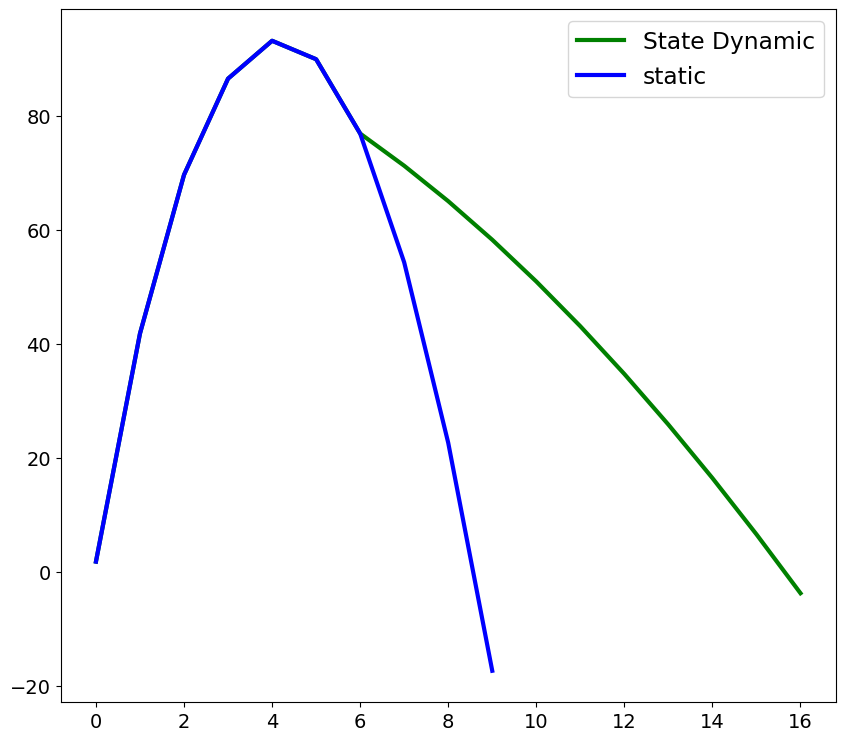

In [57]:
# New Results
simulated_results_dynamic = m.simulate_to_threshold(future_load, save_freq=1e-99, dt=next_time, threshold_keys=['impact'])
plt.plot(simulated_results_dynamic.outputs, color='green', label='State Dynamic')
# Static Results
simulated_results = m.simulate_to_threshold(future_load, save_freq=1e-99, dt = 1, threshold_keys=['impact'])
plt.plot(simulated_results.outputs, color='blue', label='static')

plt.legend()
plt.show()

### Example 4) Automatic Dynamic Step Size Feature

In this example, we'll demonstrate the automatic dynamic step size feature. This feature allows step size is adjusted automatically to hit each save_pt and save_freq exactly.

This can be achieved simply by setting the `dt` argument to 'auto'!

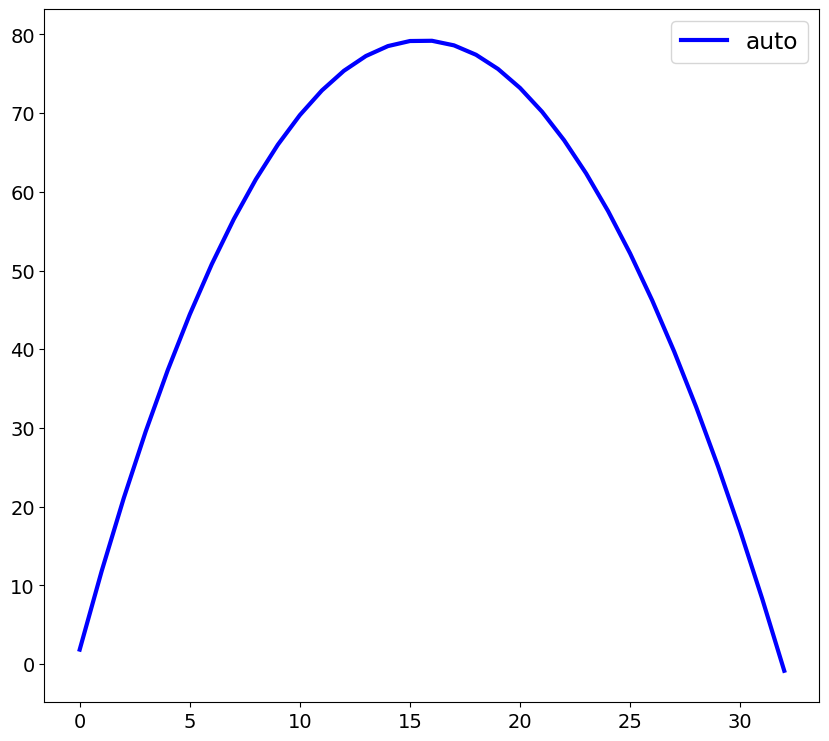

In [68]:
simulated_results_dynamic = m.simulate_to_threshold(future_load, save_freq = 0.25, dt='auto', threshold_keys=['impact'])
plt.plot(simulated_results_dynamic.outputs, color='blue', label='auto')

plt.legend()
plt.show()

Note: Depending on our save_freq, the auto step feature may produce results that are the same as the static step size feature. This can also be done with the functional dynamic step size feature.

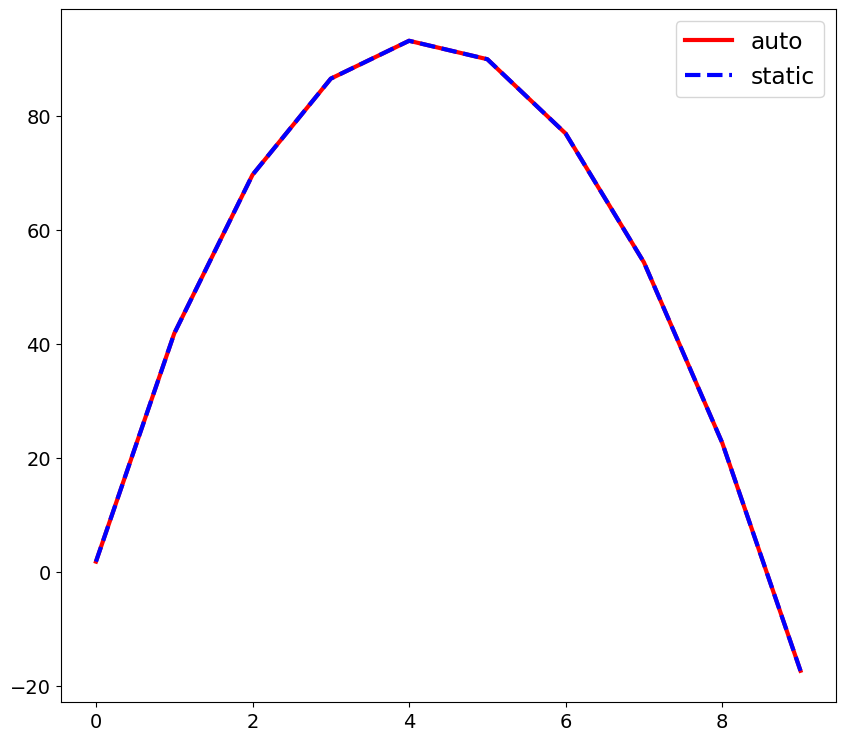

In [81]:
# Auto Results
simulated_results_dynamic = m.simulate_to_threshold(future_load, save_freq = 1, dt='auto', threshold_keys=['impact'])
plt.plot(simulated_results_dynamic.outputs, color='red', label='auto')
# Static Results
simulated_results = m.simulate_to_threshold(future_load, save_freq=1e-99, dt = 1, threshold_keys=['impact'])
plt.plot(simulated_results.outputs, color='blue', label='static', linestyle='dashed')

plt.legend()
plt.show()

Notice that the two graphs overlap one another even though we are using two different features!

### Example 5) Bounded Automatic Dynamic Step Size Feature

Our final `dt` feature is the bounded automatic dynamic step size! This feature enables the step size to adjust automatically to hit each save_pt and save_freq exactly, with a maximum step size.

This is also our default behavior of our `dt` feature!

Let's take a look at how this feature works.

In [78]:
simulated_results_dynamic = m.simulate_to_threshold(future_load, save_freq = 0.2, dt=('auto', 0.5), threshold_keys=['impact'])
plt.plot(simulated_results_dynamic.outputs, color='blue', label='auto')

plt.legend()
plt.show()

KeyboardInterrupt: 

In this notebook, we showed some examples of dynamically changing the step step size depending on either state or time. This feature is useful for simulating systems that have a changing dynamic behavior.